# Network-Constrained Spatial Clustering

Author: [Geoff Boeing](https://geoffboeing.com/)

Cluster a set of firms based on their network distances from each other. That is, two locations may be close to each other spatially, but are they close to each other along the network that constrains travel?

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [1]:
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
from sklearn.neighbors import sort_graph_by_row_values

In [2]:
# model the street network
latlon = (37.8226, -122.2340)
G = ox.graph.graph_from_point(latlon, dist=1500, network_type="drive")

## Create a fake set of firms

In [3]:
# fake data: create n_firms randomly distributed across 3 firm centers
n_firms = 30
center_latlons = [(37.8175, -122.2316), (37.8216, -122.2439), (37.8268, -122.2286)]

In [4]:
# randomly scatter the firms around the centers
np.random.seed(0)
scale = 0.001
size = int(n_firms / len(center_latlons))
firm_lats = []
firm_lons = []
for lat, lon in center_latlons:
    firm_lons.extend(np.random.normal(loc=lon, scale=scale, size=size))
    firm_lats.extend(np.random.normal(loc=lat, scale=scale, size=size))

firms = pd.DataFrame({"lat": firm_lats, "lon": firm_lons})
len(firms)

30

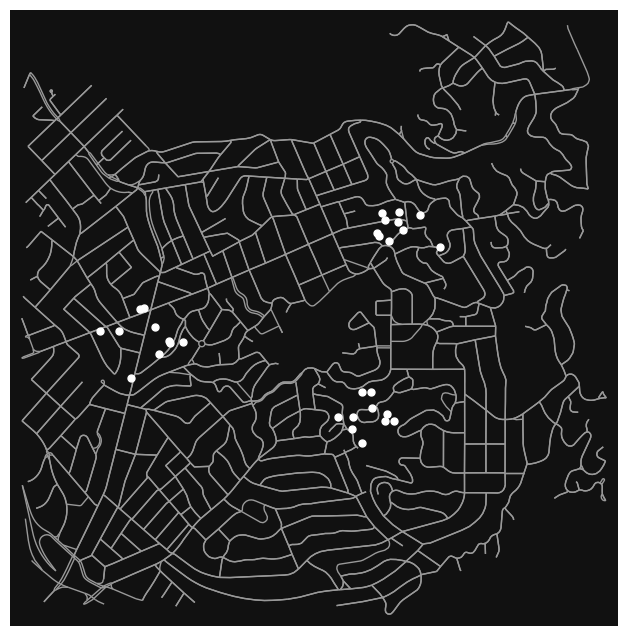

In [5]:
# plot the firms and the points around which they cluster
fig, ax = ox.plot.plot_graph(G, node_color="#aaaaaa", node_size=0, show=False, close=True)
ax.scatter(x=firms["lon"], y=firms["lat"], c="w", marker=".", s=100, zorder=2)
fig.canvas.draw()
fig

## Regular spatial clustering with DBSCAN

In [6]:
# parameterize DBSCAN
eps = 300  # meters
minpts = 3  # smallest cluster size allowed

In [7]:
# compute DBSCAN using great-circle distances
eps_rad = eps / 3671000.0  # meters to radians
db = DBSCAN(eps=eps_rad, min_samples=minpts, metric="haversine", algorithm="ball_tree")
firms["spatial_cluster"] = db.fit_predict(np.deg2rad(firms[["lat", "lon"]]))
len(firms["spatial_cluster"].unique())

3

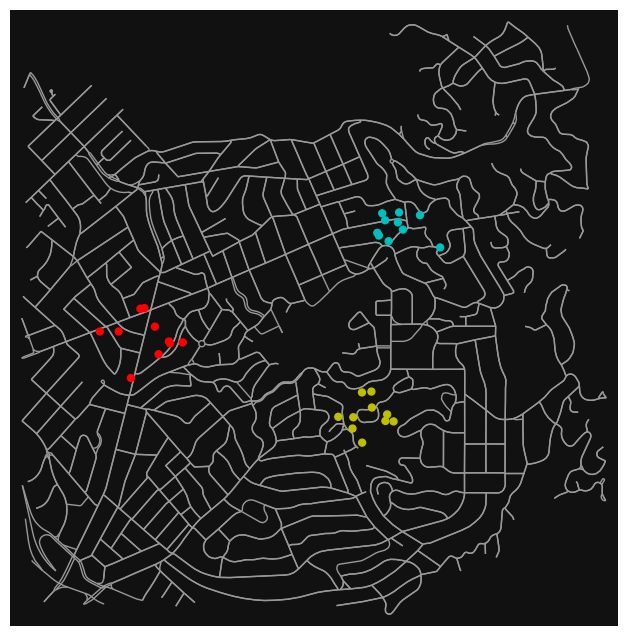

In [8]:
# plot firms by cluster
color_map = {-1: "w", 0: "y", 1: "r", 2: "c", 3: "b"}
point_colors = [color_map[c] for c in firms["spatial_cluster"]]
fig, ax = ox.plot.plot_graph(G, node_size=0, show=False, close=True)
ax.scatter(x=firms["lon"], y=firms["lat"], c=point_colors, marker=".", s=100, zorder=2)
fig.canvas.draw()
fig

## Create network-constrained distance matrix

Speed up the distance matrix computation: rather than calculating every firm to every firm, find every node with at least 1 firm attached, then calculate every such node to every such node distance. Once we have the node-to-node distances, reindex it to make those distances firm-to-firm.

In [9]:
# attach nearest network node to each firm
firms["nn"] = ox.distance.nearest_nodes(G, X=firms["lon"], Y=firms["lat"])
len(firms["nn"])

30

In [10]:
# get distances for each pair of nodes that have firms attached to them
nodes_unique = pd.Series(firms["nn"].unique())
nodes_unique.index = nodes_unique.values
len(nodes_unique)

17

In [11]:
def network_distance_matrix(u, D, vs=nodes_unique):
    dists = (nx.dijkstra_path_length(D, source=u, target=v, weight="length") for v in vs)
    return pd.Series(dists, index=vs)


# create node-based distance matrix
# convert DiGraph for simpler faster distance matrix calculation
D = ox.convert.to_digraph(G, weight="length")
node_dm = nodes_unique.apply(network_distance_matrix, D=D)
node_dm = node_dm.astype(int)
node_dm.size

289

## Make distance matrix sparse

In a regular distance matrix, zero elements are considered neighbors (they're on top of each other). With a sparse matrix only nonzero elements may be considered neighbors for DBSCAN. First, make all zeros a very small number instead, so we don't ignore them. Otherwise, we wouldn't consider two firms attached to the same node as cluster neighbors. Then set everything bigger than epsilon to 0, so we do ignore it as we won't consider them neighbors anyway.

In [12]:
node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

In [13]:
# reindex node-based distance matrix to create network-based distance matrix
net_dm = node_dm.reindex(index=firms["nn"], columns=firms["nn"])
net_dm.size

900

In [14]:
# convert network-based distance matrix to a sparse matrix
net_dm_sparse = sort_graph_by_row_values(csr_matrix(net_dm), warn_when_not_sorted=False)

## Cluster firms along the network

Use the sparse network-based distance matrix to compute DBSCAN (converges much faster and uses much less memory than using the dense matrix with a big data set).

In [15]:
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric="precomputed")
firms["network_cluster"] = db.fit_predict(net_dm_sparse)
len(firms["network_cluster"].unique())

4

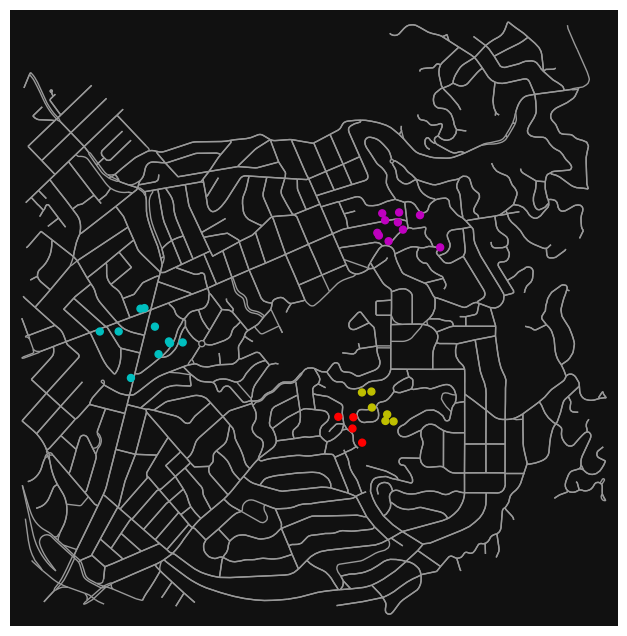

In [16]:
# plot firms by cluster
color_map = {-1: "w", 0: "y", 1: "r", 2: "c", 3: "m"}
point_colors = [color_map[c] for c in firms["network_cluster"]]
ns = [50 if n in firms["nn"].values else 0 for n in G.nodes()]
fig, ax = ox.plot.plot_graph(G, node_color="gray", node_size=0, show=False, close=True)
ax.scatter(x=firms["lon"], y=firms["lat"], c=point_colors, marker=".", s=100, zorder=3)
fig.canvas.draw()
fig

In [17]:
# compare firms' spatial clusters to network-based clusters
firms = firms.reindex(columns=["lon", "lat", "nn", "spatial_cluster", "network_cluster"])
firms.iloc[4:9]

,lon,lat,nn,spatial_cluster,network_cluster
4,-122.229732,37.817944,53156417,0,0
5,-122.232577,37.817834,53068826,0,1
6,-122.230650,37.818994,53156417,0,0
7,-122.231751,37.817295,260707482,0,1
8,-122.231703,37.817813,53068826,0,1
